[View in Colaboratory](https://colab.research.google.com/github/paulanavarretec/RecSys/blob/master/Pr%C3%A1ctico_pyreclab.ipynb)

# Ayudantía 1 - Sistemas Recomendadores: Pyreclab

En este práctico vamos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile, para aprender sobre algoritmos básicos y tradicionales de sistemas de recomendacion:


*   Most Popular
*   Item Average Rating
*   User KNN (Filtrado colaborativo basado en usuarios)


**Autores**: Denis Parra, Gabriel Sepúlveda

**Adaptado para Sistemas Recomendadores (IIC3633) por**: Manuel Cartagena, Antonio Ossa


## Setup

Vaya ejecutando cada celda presionando el botón de Play o presionando Ctrl+Enter (Linux y Windows) o Command+Enter (OSX)

**Paso 1:** Descargue los siguientes tres archivos, siguiendo los links, a su computador local (`u1.base`, `u1.test` y `u.item`, respectivamente)

https://drive.google.com/file/d/1Anro2DyEgN0sUHXFyxVe2qoSya6hzQSp/view?usp=sharing

https://drive.google.com/file/d/1Awy3QKCdkSpNeRXATqRBUMi56M47Ia0n/view?usp=sharing

https://drive.google.com/file/d/1B7QhEodQ13QlOHOTp9zaa52exlfgAOl3/view?usp=sharing


In [2]:
# Ejecute esta celda. Deberá subir los archivos u1.base, u1.test y u.item
from google.colab import files
uploaded = files.upload()

Saving u.item to u.item
Saving u1.base to u1.base
Saving u1.test to u1.test


Los archivos u1.base y u1.test tienen tuplas {usuario, item, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/).

Revisemos cómo es uno de estos archivos:

In [3]:
import pandas as pd

train_file = pd.read_csv('u1.base',
                         sep='\t',
                         names = ['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
print(train_file.head())
train_file.tail()

   userid  itemid  rating  timestamp
0       1       1       5  874965758
1       1       2       3  876893171
2       1       3       4  878542960
3       1       4       3  876893119
4       1       5       3  889751712


,userid,itemid,rating,timestamp
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275
79999,943,1330,3,888692465


Por otra parte, para obtener información adicional de cada película tal como *título*, *fecha de lanzamient*o, *género*, etc., cargaremos el archivo de items descargado ( *u.item* ) para poder mapear cada identificador de ítem al conjunto de datos que lo describe.
Revisemos el contenido de este archivo

In [4]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

info_file = pd.read_csv('u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

(info_file.head())

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs (le agregué que aparte me muestre otras características)
pelis = [5,4,1,2,3]
info_file.loc[pelis][['title', 'release_date','Adventure']]

,title,release_date,Adventure
movieid,,,
5,Copycat (1995),01-Jan-1995,0
4,Get Shorty (1995),01-Jan-1995,0
1,Toy Story (1995),01-Jan-1995,0
2,GoldenEye (1995),01-Jan-1995,1
3,Four Rooms (1995),01-Jan-1995,0


**Paso 2:** Instalar `pyreclab`



In [6]:
!pip install pyreclab

    100% |████████████████████████████████| 143kB 13.1MB/s 


**Paso 3:** Importar `pyreclab` y `numpy`

In [0]:
import pyreclab
import numpy as np

## Uso de algoritmos

### *Most Popular*

In [0]:
# Declarar el objeto recomendador de la clase MostPopular
mymp = pyreclab.MostPopular(dataset='u1.base',
                            dlmchar= b'\t',
                            header=False,
                            usercol=0,
                            itemcol=1,
                            ratingcol=2)


In [0]:
# Entrenamos el modelo con los datos existentes
mymp.train()

El método ***Most Popular*** calcula el número de veces que fue consumido cada ítem, así puede recomendar los más populares. Con este método no podemos predecir *ratings*, pero sí podemos recomendar. La recomendación no es personalizada, es la misma para todos los usuarios.

In [10]:
print("Recomendaciones para el usuario 457")
reclist = mymp.recommend("457") #457
print(reclist)
pelis = np.array(reclist).astype(int)
print(info_file.loc[pelis]['title'])

print("\nRecomendaciones para el usuario 1")
reclist = mymp.recommend("1")
print(reclist)
pelis = np.array(reclist).astype(int)
print(info_file.loc[pelis]['title'])


Recomendaciones para el usuario 457
['181', '258', '294', '127', '56', '237', '7', '172', '405', '313']
movieid
181          Return of the Jedi (1983)
258                     Contact (1997)
294                   Liar Liar (1997)
127              Godfather, The (1972)
56                 Pulp Fiction (1994)
237               Jerry Maguire (1996)
7                Twelve Monkeys (1995)
172    Empire Strikes Back, The (1980)
405         Mission: Impossible (1996)
313                     Titanic (1997)
Name: title, dtype: object

Recomendaciones para el usuario 1
['124', '419', '203', '732', '367', '751', '566', '319', '147', '514']
movieid
124                   Lone Star (1996)
419                Mary Poppins (1964)
203                  Unforgiven (1992)
732                        Dave (1993)
367                    Clueless (1995)
751         Tomorrow Never Dies (1997)
566    Clear and Present Danger (1994)
319    Everyone Says I Love You (1996)
147    Long Kiss Goodnight, The (1996)
514   

In [11]:
# Con esto podemos ver las recomendaciones con titulo de película
pelis = np.array(reclist).astype(int)
info_file.loc[pelis]['title']

movieid
124                   Lone Star (1996)
419                Mary Poppins (1964)
203                  Unforgiven (1992)
732                        Dave (1993)
367                    Clueless (1995)
751         Tomorrow Never Dies (1997)
566    Clear and Present Danger (1994)
319    Everyone Says I Love You (1996)
147    Long Kiss Goodnight, The (1996)
514                  Annie Hall (1977)
Name: title, dtype: object

### *Item Average*

In [0]:
# Declarar el objeto recomendador ItemAvg
myitemavg = pyreclab.ItemAvg(dataset='u1.base',
                             dlmchar=b'\t',
                             header=False,
                             usercol=0,
                             itemcol=1,
                             ratingcol=2)


In [0]:
# Entrenamos el modelo con los datos existentes
myitemavg.train()

In [14]:
reclist = myitemavg.recommend("457")
print(reclist)
reclist = myitemavg.recommend("1")
print(reclist)

pelis = np.array(reclist).astype(int)
info_file.loc[pelis]['title']

['1500', '1653', '1599', '1189', '1467', '1293', '1201', '1122', '1449', '1367']
['1500', '1653', '1599', '1189', '1467', '1293', '1201', '1122', '1449', '1367']


movieid
1500                            Santa with Muscles (1996)
1653    Entertaining Angels: The Dorothy Day Story (1996)
1599                        Someone Else's America (1995)
1189                                   Prefontaine (1997)
1467                 Saint of Fort Washington, The (1993)
1293                                      Star Kid (1997)
1201           Marlene Dietrich: Shadow and Light (1996) 
1122                       They Made Me a Criminal (1939)
1449                               Pather Panchali (1955)
1367                                         Faust (1994)
Name: title, dtype: object

#### Preguntas

**¿Qué cree usted que hace la función `train()` del método de recomendación  `ItemAvg()`?**

**Respuesta:** Lo que hace es aprender el rating promedio para cada película. A continuación el código que la implementa :



```
int AlgItemAvg::train()
{
   for( size_t col = 0 ; col < m_ratingMatrix.items() ; ++col )
   {
      double sumbycol = 0;
      int countbycol = m_ratingMatrix.sumColumn( col, sumbycol );
      if( 0 < countbycol )
      {
         m_meanRatingByItemCol[col] = sumbycol/countbycol;
      }

      if( !m_running )
      {
         return STOPPED;
      }
   }

   return FINISHED;
} 

```
[Fuente](https://github.com/gasevi/pyreclab/blob/master/algorithms/AlgItemAvg.cpp)



In [15]:
# Predecir rating que el usuario ID 457 le dará al ítem ID 37
print(myitemavg.predict('457', '37'))
myitemavg.predict('1', '37')

2.3333332538604736


2.3333332538604736

**Ejecute el mismo comando anterior para predecir esta vez el rating que el usuario 498 dará al item 37 ¿Qué rating da? ¿Cómo se explica este resultado?**

In [17]:
# COMPLETAR

myitemavg.predict('498', '37')

2.3333332538604736

**Respuesta:** Este resultado se explica porque este algoritmo funciona asignando a la predicción el rating promedio que toda la comunidad le ha dado a ese item. Por lo que a todos los usuarios les dará la misma predicción para el mismo item.

In [18]:
# Generar lista de 5 recomendaciones para el usuario con ID 457

reclist_iavg = myitemavg.recommend('457', 5)
print(reclist_iavg)

['1500', '1653', '1599', '1189', '1467']


**Genere una lista de 10 recomendaciones para el usuario ID 478 ¿Cómo se explican las recomendaciones del método para este usuario comparadas con las del usuario 457?**

In [19]:
# COMPLETAR
reclist = myitemavg.recommend('478', 10  )
print("Recomendación user 478 ", reclist)
print("Recomendación user 457 ", myitemavg.recommend('457', 10 ))

for item in range(len(reclist)):
  reclist_iavg = myitemavg.predict('457', reclist[item])
  print((item+1),") ",reclist_iavg)

Recomendación user 478  ['1500', '1653', '1599', '1189', '1467', '1293', '1201', '1122', '1449', '1367']
Recomendación user 457  ['1500', '1653', '1599', '1189', '1467', '1293', '1201', '1122', '1449', '1367']
1 )  5.0
2 )  5.0
3 )  5.0
4 )  5.0
5 )  5.0
6 )  5.0
7 )  5.0
8 )  5.0
9 )  4.714285850524902
10 )  4.666666507720947


**Respuesta:** Este resultado se explica por la misma razón anterior, dado que a todos los usuarios les dará la misma predicción para el mismo item, lógicamente los 10 itemes mejor rankeados serán los mismos para toda la comunidad.


**¿Cuáles son los títulos de las películas recomendadas por el método *ItemAvg* para el usuario 457 ? ¿Qué le parecen estas recomendaciones comparadas con el método *MostPopular*?**

In [20]:
# COMPLETAR
print("Item Avg para usuario 457")
pelis = np.array(reclist).astype(int)
print(info_file.loc[pelis][['title', 'release_date']])

print("\nMost Popular para usuario 457")
pelis = np.array(mymp.recommend("457")).astype(int)
print(info_file.loc[pelis][['title', 'release_date']])

Item Avg para usuario 457
                                                     title release_date
movieid                                                                
1500                             Santa with Muscles (1996)  08-Nov-1996
1653     Entertaining Angels: The Dorothy Day Story (1996)  27-Sep-1996
1599                         Someone Else's America (1995)  10-May-1996
1189                                    Prefontaine (1997)  24-Jan-1997
1467                  Saint of Fort Washington, The (1993)  01-Jan-1993
1293                                       Star Kid (1997)  16-Jan-1998
1201            Marlene Dietrich: Shadow and Light (1996)   02-Apr-1996
1122                        They Made Me a Criminal (1939)  01-Jan-1939
1449                                Pather Panchali (1955)  22-Mar-1996
1367                                          Faust (1994)  01-Jan-1994

Most Popular para usuario 457
                                   title release_date
movieid                  

**Respuesta:** El fondo está en que reflejan cosas distintas, most popular no refleja "valoración" por parte de la comunidad al item, si no que refleja "popularidad" (en terminos de qué tan visto ha sido) por parte de la comunidad  un item en particular, y puede ser que aunque la comunidad no valore de forma positiva las películas, estas saldrán recomendadas igual al comienzo de la lista. Esto no pasa con AvgItem, el problema con AvgItem es que items con muy pocos ratings y todos buenos pueden estar mas arriba en la lista de recomendación que items con muchas recomendaciones buenas y una fraccion mala (que generen que el promedio sea menor que el máximo), entonces puede caer en el mismo paradigma anterior en que falla en captar la valoración de la comunidad frente a la introducción al sistema de nuevos items.

### Wilson score

Otra forma de recomendar cuando se tienen votos positivos y negativos es usando el lower bound del wilson-score como se muestra en https://www.evanmiller.org/how-not-to-sort-by-average-rating.html

Como el dataset de movielens contiene ratings, una forma de contabilizar estos como votos es asignando los ratings superiores a un valor definido como votos positivos y los demás como negativos.

In [0]:
from math import sqrt
import scipy.stats as st

def ci_lower_bound(pos, neg, confidence=.95):
    n = pos + neg

    if n == 0:
        return 0

    #z = 1.0 #1.44 = 85%, 1.96 = 95%
    z = st.norm.ppf(1-(1-confidence)/2)
    phat = float(pos) / n
    
    return (phat + z*z/(2*n) - z * sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n)

In [0]:
item_count = {}
for tup in train_file.groupby(['itemid', 'rating']).agg(['count']).itertuples():
  if tup[0][0] not in item_count:
    item_count[tup[0][0]] = {}
    item_count[tup[0][0]]['pos'] = 0
    item_count[tup[0][0]]['neg'] = 0

  if tup[0][1] <= 4:
    item_count[tup[0][0]]['neg'] += tup[1]
  else:
    item_count[tup[0][0]]['pos'] += tup[1]
    
    
item_count2 = {}
for tup in train_file.groupby(['itemid', 'rating']).agg(['count']).itertuples():
  if tup[0][0] not in item_count2:
    item_count2[tup[0][0]] = {}
    item_count2[tup[0][0]]['pos'] = 0
    item_count2[tup[0][0]]['neg'] = 0

  if tup[0][1] <= 3:
    item_count2[tup[0][0]]['neg'] += tup[1]
  else:
    item_count2[tup[0][0]]['pos'] += tup[1]

A partir de la funcion ci_lower_bound y el diccionario item_count genere una lista de recomendación usando el wilson score.

In [87]:
# len(item_count)
# print((item_count.keys()))
# type(item_count[len(item_count)+1])
# item_count[1]['pos']
# item_count[1]['neg']

from collections import Counter

ws_list = Counter()
ws_list2 = Counter()
ws_list3 = Counter()


print("\tpos\tneg\t       Wilson score")
for item in item_count:
  ws_list[(item)] = ci_lower_bound(item_count[item]['pos'], item_count[item]['neg'], confidence=.95)
  ws_list2[(item)] = ci_lower_bound(item_count2[item]['pos'], item_count2[item]['neg'], confidence=.95)
  ws_list3[(item)] = ci_lower_bound(item_count[item]['pos'], item_count[item]['neg'], confidence=.99)
  
ws_list = (sorted(ws_list.items(), key=lambda pair: pair[1], reverse=True)) 
ws_list2 = (sorted(ws_list2.items(), key=lambda pair: pair[1], reverse=True)) 
ws_list3 = (sorted(ws_list3.items(), key=lambda pair: pair[1], reverse=True)) 


print("Wilson score para usuario 457")
pelis = [k for k,l in ws_list]
pelis2 = [k for k,l in ws_list2]
pelis3 = [k for k,l in ws_list3]

ratings =  [(item_count[k]['pos'],item_count[k]['neg']) for k in pelis]
ratings2 =  [(item_count2[k]['pos'],item_count2[k]['neg']) for k in pelis2]
ratings3 =  [(item_count[k]['pos'],item_count[k]['neg']) for k in pelis3]

print(info_file.loc[pelis[:10]][['title', 'release_date']])

print("\nWilson Score - Preg.1:",ws_list[:10])
print("evaluaciones (pos/neg):", ratings[:10])

print("\nWilson Score - Preg.2:",ws_list2[:10])
print("evaluaciones (pos/neg):",ratings2[:10])

print("\nWilson Score - Preg.3:",ws_list3[:10])
print("evaluaciones (pos/neg):",ratings3[:10])


	pos	neg	       Wilson score
Wilson score para usuario 457
                                    title release_date
movieid                                               
318               Schindler's List (1993)  01-Jan-1993
408                 Close Shave, A (1995)  28-Apr-1996
169            Wrong Trousers, The (1993)  01-Jan-1993
50                       Star Wars (1977)  01-Jan-1977
483                     Casablanca (1942)  01-Jan-1942
64       Shawshank Redemption, The (1994)  01-Jan-1994
12             Usual Suspects, The (1995)  14-Aug-1995
313                        Titanic (1997)  01-Jan-1997
127                 Godfather, The (1972)  01-Jan-1972
1293                      Star Kid (1997)  16-Jan-1998

Wilson Score - Preg.1: [(318, 0.5784826200085438), (408, 0.5549092077246491), (169, 0.5191274393745442), (50, 0.5153938358658606), (483, 0.5093214077883184), (64, 0.49939802101539893), (12, 0.49178606769296224), (313, 0.4611521755653467), (127, 0.44715073217160467), (1293, 0.4385

PREGUNTAS:
1. Cómo considera este ranking respecto a Most Popular y a Rating Promedio? explique.

**RESPUESTA:** Este algoritmo corrige las anomalías discutidas en la sección anterios, ya que balancea en la proporción de items positivos con la incertidumbre introducida por items con pocas evaluaciones, por lo tanto, lo que nos dice es qué porcentaje de las personas que vean este item lo evalúen positivamente, con un 95% de confianza. Esto evita que items con pocas evaluaciones queden arriba en la lista

2. Cuál sería el efecto en el ranking de cambiar el umbral de rating positivo de  $r \geq 4$ a $r \geq 3$

**RESPUESTA:** 
Al bajar el umbral para discriminar rating positivos lo que ocurre es que una fracción de ratings que antes eran considerados negativos ahora son considerados positivos, por lo que la proporción de ratings negativos baja y esto se ve penalizado pudiendo bajar de relevancia algunos items. Por ejemplo, con el umbral fijo en 4, el item *408 (A Close Shave)* queda recomendado en la segunda posición, con una proporcion de ratings positivos de (61/93), pero al bajarlo a 3, la proporción sube  a *(84/93)*  (aumentando la asimetría en la función de probabilidad que es luego usada para generar el intervalo), lo que se ve penalizado drásticamente en término $p_+ *(1-p_+)$, haciendo que baje su ranking al 7° lugar en el segundo caso, algo similar ocurre con el item *169 (The Wrong Trousers)*  o *50 (Star Wars)*. En el fondo lo que ocurre es el que modelo se robustece frente a desviaciones de la normalidad de $p_+$ (en el sentido de una distribución normal donde la mitad de los casos cae a cada lado de la curva, ver figura).

![alt text](https://i.stack.imgur.com/pwqMa.png)


3. Cuál es el efecto de cambiar el valor (1-$\alpha$) de 0.95 a 0.99 en la lista rankeada ?

**RESPUESTA:** Naturalmente, al aumentar el nivel de confianza, el algoritmo se robustece más frente a las asimetrías mencionadas recientemente, por lo que algunos itemes, más simétricos en su distribución o con un mejor tamaño de muestra, quedarán mejor rankeados, como lo que pasa con los itemes *169 (The Wrong Trousers)*  o *50 (Star Wars)* con un $p_+$ de 0,618 y 0,5599 respectivamente  (el segundo es más simétrico), que al elevar el nivel de confianza se invierten en el ranking.


### *UserKNN*

In [0]:
# Declarar el objeto recomendador UserKnn
myUserKnn = pyreclab.UserKnn(dataset='u1.base',
                             dlmchar=b'\t',
                             header=False,
                             usercol=0,
                             itemcol=1,
                             ratingcol=2)


In [0]:
# Entrenamos el modelo con los datos existentes
# Recuerde que se puede probar el parámetro k de cantidad de vecinos
# así como la métrica de similaridad (pearson, cosine)
myUserKnn.train(7, 'pearson')

#### Preguntas

**Según el modelo de recomendación UserKnn, qué rating le dará el usuario 457 al item 37 ?**

In [60]:
# COMPLETAR
prediction = myUserKnn.predict( "457", "37" )
print(prediction)

3.1338725090026855


**Respuesta:** COMPLETAR

**Escriba los nombres de las películas recomendadas por el método knn**

In [88]:
# COMPLETAR
ranking4 = myUserKnn.recommend( "457")
print(ranking4)

print("\nUser Knn Reclist para usuario 457")
pelis = np.array(ranking4).astype(int)
print(info_file.loc[pelis][['title', 'release_date']])

ratings =  [(item_count[k]['pos'],item_count[k]['neg']) for k in pelis]
print("(pos/neg) user Knn Reclist", ratings)

['1467', '1599', '1642', '1653', '1358', '1233', '1449', '1500', '1361', '1293']

User Knn Reclist para usuario 457
                                                     title release_date
movieid                                                                
1467                  Saint of Fort Washington, The (1993)  01-Jan-1993
1599                         Someone Else's America (1995)  10-May-1996
1642                              Some Mother's Son (1996)  27-Dec-1996
1653     Entertaining Angels: The Dorothy Day Story (1996)  27-Sep-1996
1358                                The Deadly Cure (1996)  16-Sep-1996
1233                               NÃ©nette et Boni (1996)  01-Jan-1996
1449                                Pather Panchali (1955)  22-Mar-1996
1500                             Santa with Muscles (1996)  08-Nov-1996
1361                  Search for One-eye Jimmy, The (1996)  01-Jan-1996
1293                                       Star Kid (1997)  16-Jan-1998
(pos/neg) user Knn R

**Respuesta:** COMPLETAR (Respuesta en el output arriba)

Analizar de tal forma de minimizar el número de vecinos viendo el error (RMSE)

Un ejemplo de como obtener las listas de recomendación junto con sus métricas para el dataset de test:

In [0]:
predlist, mae, rmse = myUserKnn.test(input_file='u1.test',
                                     dlmchar=b'\t',
                                     header=False,
                                     usercol=0,
                                     itemcol=1,
                                     ratingcol=2,
                                     output_file='predictions.csv')

In [63]:
print(mae, rmse)

0.7905333901762914 1.005357873576839


A partir del ejemplo anterior probar para distintos valores de k y evaluar en base al error de prediccion (RMSE)

In [0]:
#COMPLETAR

mae_list, rmse_list = [],[]
parametros =  np.arange(1,31)

for k in parametros:
  myUserKnn.train(k, 'pearson')
  predlist, mae, rmse = myUserKnn.test(input_file='u1.test',
                                     dlmchar=b'\t',
                                     header=False,
                                     usercol=0,
                                     itemcol=1,
                                     ratingcol=2,
                                     output_file='predictions.csv')
  mae_list.append(mae)
  rmse_list.append(rmse)

In [82]:
print(parametros)
print(mae_list)
print(rmse_list)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[0.852112943425713, 0.8564303985138891, 0.8566367410259867, 0.8548673835858485, 0.8521662474352527, 0.8490600017305269, 0.8458085233108561, 0.8425869373547278, 0.8394687395129009, 0.8364828780859708, 0.8336400969134091, 0.8309609999641209, 0.8284134442475779, 0.8260008507178204, 0.8237340710169144, 0.8215526059276016, 0.8194951242873274, 0.8175616010779805, 0.8157233414820573, 0.8139738220757913, 0.8123039921653271, 0.8107137364932886, 0.8091939906237369, 0.8077409681202945, 0.806355120297454, 0.8050268483105736, 0.8037593243486968, 0.8025466707458259, 0.8013815518162865, 0.8002594415026182]
[1.091733536511761, 1.09671366102666, 1.096313933163699, 1.0935856515335283, 1.0898258440912034, 1.085632652105077, 1.081329294956156, 1.0771154839132602, 1.0730773641468987, 1.069215650726543, 1.065538268817045, 1.062076708959799, 1.0587902982289092, 1.0556698321839046, 1.052730374898029, 1.049925612282295

Graficar los resultados anteriores (MAE y RMSE), los que deberían verse algo así:

![MAE](https://fotos.subefotos.com/819d05796c6e1da8ec11637788c677aco.png)

![RMSE](https://fotos.subefotos.com/6148bcf1c0fdd7ffc0046b04f3f455b5o.png)

1.   Elemento de lista
2.   Elemento de lista



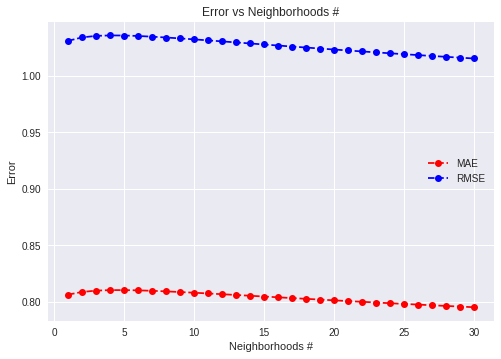

In [90]:
import matplotlib.pyplot as plt
plt.plot(parametros, mae_list, marker='o', linestyle='--', color='r', label='MAE')
plt.plot(parametros, rmse_list, marker='o', linestyle='--', color='b', label='RMSE')

# plt.plot(radius, area)
plt.xlabel('Neighborhoods #')
plt.ylabel('Error')
plt.title('Error vs Neighborhoods #')
plt.legend()
plt.show()

### *Slope One* (Opcional)

**Replicar todo el análisis de UserKNN con el método SlopeOne
**

In [0]:
mySlopeOne = pyreclab.SlopeOne(dataset='u1.base',
                             dlmchar=b'\t',
                             header=False,
                             usercol=0,
                             itemcol=1,
                             ratingcol=2)
mySlopeOne.train()

In [0]:
predlist, mae, rmse = mySlopeOne.test(input_file='u1.test',
                                     dlmchar=b'\t',
                                     header=False,
                                     usercol=0,
                                     itemcol=1,
                                     ratingcol=2,
                                     output_file='predictions.csv')

In [104]:
print("MAE:",mae,"RMSE:", rmse)

ranking5 = mySlopeOne.recommend( "457")
print(ranking5)

print("\nUser SlopeOne Reclist para usuario 457")
pelis = np.array(ranking5).astype(int)
print(info_file.loc[pelis][['title', 'release_date']])

mae_list, rmse_list = [],[]
mae_list.append(mae)
rmse_list.append(rmse)


MAE: 0.7828952915105929 RMSE: 0.9946687256820582
['1500', '1656', '1653', '1651', '1650', '1645', '1643', '1642', '1639', '1636']

User SlopeOne Reclist para usuario 457
                                                     title release_date
movieid                                                                
1500                             Santa with Muscles (1996)  08-Nov-1996
1656                                    Little City (1998)  20-Feb-1998
1653     Entertaining Angels: The Dorothy Day Story (1996)  27-Sep-1996
1651                          Spanish Prisoner, The (1997)  27-Mar-1998
1650                               Butcher Boy, The (1998)  01-Jan-1998
1645                               Butcher Boy, The (1998)  01-Jan-1998
1643                                     Angel Baby (1995)  10-Jan-1997
1642                              Some Mother's Son (1996)  27-Dec-1996
1639                   Bitter Sugar (Azucar Amargo) (1996)  22-Nov-1996
1636                            Brothe

### *ItemKNN* (Opcional)

**Replicar todo el análisis de UserKNN con el método ItemKNN**

In [0]:
myItemKnn = pyreclab.ItemKnn(dataset='u1.base',
                             dlmchar=b'\t',
                             header=False,
                             usercol=0,
                             itemcol=1,
                             ratingcol=2)
myItemKnn.train()

In [0]:
predlist, mae, rmse = myItemKnn.test(input_file='u1.test',
                                     dlmchar=b'\t',
                                     header=False,
                                     usercol=0,
                                     itemcol=1,
                                     ratingcol=2,
                                     output_file='predictions.csv')

In [107]:
print("MAE:",mae,"RMSE:", rmse)

ranking6 = myItemKnn.recommend( "457")
print(ranking6)

print("\nUser ItemKnn Reclist para usuario 457")
pelis = np.array(ranking6).astype(int)
print(info_file.loc[pelis][['title', 'release_date']])

mae_list.append(mae)
rmse_list.append(rmse)

x = ["SlopeOne", "ItemKnn"]

print(len(x),len(mae_list), len(rmse_list))

MAE: 0.7828952915105929 RMSE: 0.9946687256820582
['1449', '1367', '1639', '1642', '119', '1064', '272', '1594', '850', '515']

User ItemKnn Reclist para usuario 457
                                          title release_date
movieid                                                     
1449                     Pather Panchali (1955)  22-Mar-1996
1367                               Faust (1994)  01-Jan-1994
1639        Bitter Sugar (Azucar Amargo) (1996)  22-Nov-1996
1642                   Some Mother's Son (1996)  27-Dec-1996
119      Maya Lin: A Strong Clear Vision (1994)  01-Jan-1994
1064                           Crossfire (1947)  01-Jan-1947
272                    Good Will Hunting (1997)  01-Jan-1997
1594                             Everest (1998)  10-Mar-1998
850                 Perfect Candidate, A (1996)  27-Sep-1996
515                            Boot, Das (1981)  04-Apr-1997
2 2 2


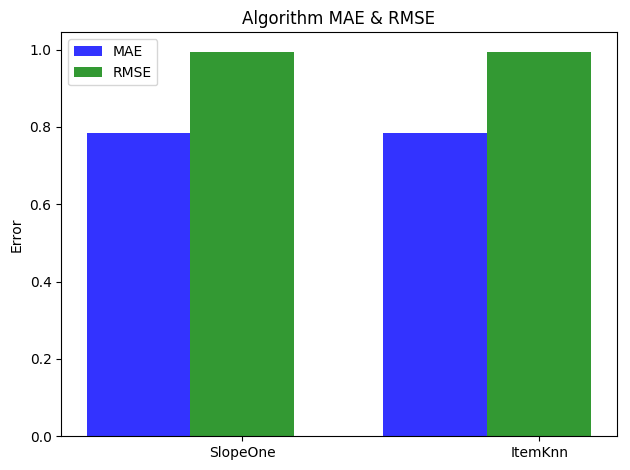

In [116]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to plot
n_groups = 2
means_frank = (90, 55, 40, 65)
means_guido = (85, 62, 54, 20)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, mae_list, bar_width,
                 alpha=opacity,
                 color='b',
                 label='MAE')
 
rects2 = plt.bar(index + bar_width, rmse_list, bar_width,
                 alpha=opacity,
                 color='g',
                 label='RMSE')
 
plt.ylabel('Error')
plt.title('Algorithm MAE & RMSE')
plt.xticks(index + bar_width, ('SlopeOne', 'ItemKnn'))



plt.legend()
 
plt.tight_layout()
plt.show()